# FilmForecast
## Project aiming at Predicting Movie Ratings using Methods of Machine Learning

### Topic : Predict the Rating of Movies

#### by:
#### Valentin Straßer (Matrikelnummer: 12345678),
#### Mathusan Saravanapavan (Matrikelnummer: 98765432),
#### Michał Roziel (Matrikelnummer: 11223344)

#### The goal in this project is to predict the rating (vote_average) of movies based on other features (e.g., their release date and box-office revenue).


#### Data :

The TMDB Movies Dataset consists of information about 1 million movies scraped from IMDB. The dataset is available for download from Moodle. More information about the dataset can be found here:

https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies/data


#### Goals :

Employing the methods that we covered in the lecture, you should come up with your own solution to the problem and evaluate it. In order to obtain bonus points, you have to submit your solution as a single Jupyter Notebook by August 30, 2025. Your Jupyter notebook should cover the following aspects:

some analysis of the dataset (e.g., statistics regarding its size or the distribution of individual features)
details on any preprocessing that you applied to the dataset (e.g., to clean it up by removing null values)
a detailed description of your approach (e.g., which method to do you use, which features do you consider)
a discussion of the experimental results (e.g., what is the performance that your achieves, how does it compare to other methods)


In [270]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MultiLabelBinarizer, PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../Database/Dataset.csv")
df_raw = df.copy()  # Keep a backup of the original dataset

In [271]:
df.shape

(1266865, 24)

In [272]:
print(df.columns.tolist())

['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']


### 1. Analysis of the Dataset

The dataset, sourced from TMDB, contains information on approximately 930,000 movies.

**Initial Observations and Cleaning:**
*   **Size**: The original dataset has `(936336, 25)` dimensions.
*   **Null Values**: A preliminary analysis revealed that several columns, such as `belongs_to_collection`, `homepage`, and `tagline`, contained more than 50% null values. These columns were dropped as they would not provide reliable features for the model. After this step, the dataset was reduced to 19 columns.
*   **Feature Distribution**:
    *   The target variable, `vote_average`, is a continuous value, making this a regression problem.
    *   Features like `budget` and `revenue` are heavily skewed, with many movies having zero or low values. This suggests that a logarithmic transformation or scaling is necessary.
    *   The `genres` column is in a JSON-like format and needs to be parsed to be usable as features.
    *   `original_language` is a categorical feature that can be one-hot encoded.

In [273]:
# Initial Data Cleaning - Remove Columns with Too Many Null Values

# 1. Set a threshold for null values (50%).
# Columns with more null values than the threshold will be dropped.
threshold = len(df) * 0.5

# Count null values for each column.
null_counts = df.isnull().sum()


# 2. Identify columns where the null count exceeds the threshold.
cols_to_drop = null_counts[null_counts > threshold].index.tolist()

# 3. Drop the identified columns.
df = df.drop(columns=cols_to_drop)

print("Original shape:", df_raw.shape)
print("Cleaned shape:", df.shape)
print("----------------------------------------\n")

# Check which columns were dropped.
# Use set difference to find the dropped columns.
dropped_cols = set(df_raw.columns) - set(df.columns)
print("Dropped columns:", dropped_cols)
print("----------------------------------------")
print("----------------------------------------")
print("----------------------------------------")
print("Remaining columns:", df.columns.tolist())

Original shape: (1266865, 24)
Cleaned shape: (1266865, 19)
----------------------------------------

Dropped columns: {'keywords', 'homepage', 'backdrop_path', 'production_companies', 'tagline'}
----------------------------------------
----------------------------------------
----------------------------------------
Remaining columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'genres', 'production_countries', 'spoken_languages']


In [274]:
# Second Data Cleaning
# Drop columns that are not needed for the model.

cols_to_drop_for_model = [
    'id',
    'title',
    'original_title',
    'imdb_id',
    'poster_path',
    'overview',
    'vote_average',
    'production_countries', # already using original language and genres
    'spoken_languages' # already using original language
]

features = df.drop(columns=cols_to_drop_for_model)
target = df['vote_average']



print("Original DataFrame:", df.shape)
print("Features DataFrame:", features.shape)
print("-------------------------------------------")
print("The Features we are going to be using:", features.columns.tolist())



Original DataFrame: (1266865, 19)
Features DataFrame: (1266865, 10)
-------------------------------------------
The Features we are going to be using: ['vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'budget', 'original_language', 'popularity', 'genres']


In [275]:
# check values in different columns

#print(df['status'].value_counts(dropna=False))
#print(df['adult'].value_counts(dropna=False))
#print(df['original_language'].value_counts())
df['genres'].describe()

count          733450
unique          14128
top       Documentary
freq           147145
Name: genres, dtype: object

In [276]:
# https://stackoverflow.com/questions/58033652/separating-categories-within-one-column-in-my-dataframe?utm_source=chatgpt.com

def extract_genres(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

df['genre_list'] = df['genres'].apply(extract_genres)



mlb = MultiLabelBinarizer()
df_genres = pd.DataFrame(
    mlb.fit_transform(df['genre_list']),
    columns=[f"has_{g}" for g in mlb.classes_],
    index=df.index
)
df = pd.concat([df, df_genres], axis=1)

### 2. Preprocessing and Feature Engineering

To prepare the data for modeling, the following preprocessing and feature engineering steps were applied:

*   **Feature Selection**: Columns not relevant for prediction, such as `id`, `title`, `overview`, and `poster_path`, were dropped to create the feature set. The target variable `vote_average` was separated.
*   **Handling JSON-like Columns (`genres`)**: The `genres` column was parsed to extract a list of genre names for each movie. The `MultiLabelBinarizer` was then used to convert these lists into one-hot encoded binary features (e.g., `has_Action`, `has_Comedy`), indicating the presence of each genre.
*   **Feature Transformation and Scaling**:
    *   **Logarithmic Scaling**: To handle the wide and skewed distribution of `vote_count`, a logarithmic transformation (`np.log1p`) was applied.
    *   **Numeric Scaling**: `MinMaxScaler` was used to scale `budget`, `revenue`, `runtime`, and `popularity` to a uniform range of [0, 1]. This prevents features with larger magnitudes from disproportionately influencing the model. Missing values in `runtime` were imputed with the median, while `budget` and `revenue` NaNs were filled with 0.
*   **Date Feature Extraction**: The year was extracted from the `release_date` column to create a `release_year` feature, capturing potential time-based trends in movie ratings.
*   **Categorical Feature Encoding**:
    *   **Status**: The `status` column was converted into a binary feature `status_released`, as the vast majority of movies are 'Released'.
    *   **Original Language**: The `original_language` column was converted into multiple binary features using one-hot encoding (`pd.get_dummies`).
    *   **Adult**: The boolean `adult` column was converted to an integer (0 or 1).
*   **Final Feature Set**: The final set of features used for training includes the engineered numeric, binary, and one-hot encoded features. Any remaining `NaN` values in the final feature matrix were filled with 0.

In [277]:
# Feature Engineering
scaler = MinMaxScaler()

# Convert vote_count using logarithmic scaling
# prevents extreme large values
df['vote_count_log'] = np.log1p(df['vote_count'])

# Use One Hot Encoding for the STATUS
df['status_released'] = (df['status'] == 'Released').astype(int)
# By Far the majority of movies are Released -> Binary Choice
# 1 : Released, 0 : Not Released


# Convert 'release_date' to datetime and extract the YEAR
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
# coerce -> If parsing fails, set the value to NaT (Not a Time)
df['release_year'] = df['release_date'].dt.year
df['release_year'] = df['release_year'].clip(upper=2025).clip(lower=1900)

# Normalize BUDGET and REVENUE
# Fill NaN values with 0 for budget and revenue.
df['budget'] = df['budget'].fillna(0)
df['revenue'] = df['revenue'].fillna(0)

# Scale budget and revenue between 0 and 1.
df[['budget_scaled', 'revenue_scaled']] = scaler.fit_transform(df[['budget', 'revenue']])


# Convert RUNTIME to numeric, fill NaN with median.
df['runtime'] = df['runtime'].fillna(df['runtime'].median())
df[['runtime_scaled']] = scaler.fit_transform(df[['runtime']])


# Convert ADULT to binary (1 for True, 0 for False).
# This is statistically relevant, as almost 10% of movies are for adults.
df['adult'] = df['adult'].astype(bool).astype(int)


# One Hot Encoding for ORIGINAL_LANGUAGE.
df = pd.get_dummies(df, columns=['original_language'], prefix='lang', drop_first=True)


# Min Max Scaling for POPULARITY.
df[['popularity_scaled']] = scaler.fit_transform(df[['popularity']])


# Extracting features for genres with MultiLabelBinarizer in the function above.
genre_features = [col for col in df.columns if col.startswith('has_')]

# Final list of features.
feature_cols = [
    'vote_count_log',
    'status_released',
    'release_year',
    'budget_scaled',
    'revenue_scaled',
    'runtime_scaled',
    'adult',
    'popularity_scaled',
    #'spoken_languages' — handled separately
] + genre_features + [col for col in df.columns if col.startswith('lang_')]


features = df[feature_cols]
#target = df['vote_average']



# Fill the Not a Number values with 0.
features = features.fillna(0)

### 3. Modeling Approach

To predict the movie ratings, several regression models were implemented and considered. The data was split into training (70%), validation (20%), and test (10%) sets to train the models and evaluate their performance on unseen data, which helps in preventing overfitting.

The following models were considered:
1.  **Linear Regression**: A simple baseline model to establish initial performance.
2.  **Ridge Regression**: An extension of linear regression that includes L2 regularization to reduce model complexity and prevent overfitting.
3.  **Polynomial Regression**: This approach transforms features into polynomial terms to capture non-linear relationships between the features and the movie rating.
4.  **Random Forest Regressor**: An ensemble learning method chosen for this task. It is robust, generally performs well on tabular data without extensive hyperparameter tuning, and can capture complex, non-linear interactions between features.

The **Random Forest Regressor** was selected as the final model for evaluation due to its superior predictive power and robustness compared to simpler linear models.

In [278]:
# Split Data into Training, Validation, and Test Sets
# We will use 70% for training, 20% for validation, and 10% for testing.

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html


# Splitting the Data into train and temporary sets (70% train, 30% temp).
X_train, X_temp, y_train, y_temp = train_test_split(
    # X_train : features
    # X_temp : also features, 30 percent of the data
    # y_train : target
    # y_temp : still 30 percent of the data, but not features -> target values
    features, target,
    test_size=0.30,
    )

# Splitting the Temp set into validation and test sets (50% of temp each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3,
)




In [279]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)


Training set shape: (886805, 183)
Validation set shape: (253373, 183)
Test set shape: (126687, 183)
Training target shape: (886805,)
Validation target shape: (253373,)
Test target shape: (126687,)


In [280]:
# Check for object (non-numeric) dtypes
print(features.dtypes[features.dtypes == 'object'])

# Check for missing values
print("NaNs in features:", features.isna().sum().sum())
print("NaNs in target:", target.isna().sum())

Series([], dtype: object)
NaNs in features: 0
NaNs in target: 0


In [281]:
# FUNCTION FOR LINEAR REGRESSION
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
def execute_linear_regression():
# Initialize model
    model = LinearRegression()

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Return predictions and model
    return model, y_val_pred, y_test_pred

In [282]:
# FUNCTION FOR RIDGE REGRESSION

def execute_ridge_regression():


# Initialize Ridge model.
# alpha: Regularization strength (default = 1.0).
    model = Ridge()

# Train the model.
    model.fit(X_train, y_train)

# Predictions.
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_val_pred, y_test_pred

In [283]:
# FUNCTION FOR POLYNOMIAL REGRESSION
def execute_polynomial_regression():

# Initialize model.
    model = LinearRegression()

# Select numeric features for polynomial transform; not too many to avoid heavy workload.
    numeric_features = ['vote_count_log', 'budget_scaled', 'revenue_scaled', 'runtime_scaled', 'popularity_scaled']

# Create subsets for training, validation, and testing.
    x_train_num = X_train[numeric_features]
    x_val_num = X_val[numeric_features]
    x_test_num = X_test[numeric_features]


# Create Polynomial Features of degree 2.
    poly = PolynomialFeatures(degree=2, include_bias=False)

# Here, we create polynomial features for the numeric columns.
# .to_numpy() is not needed here as fit_transform handles it.
    x_train_poly = poly.fit_transform(x_train_num)
    x_val_poly = poly.transform(x_val_num)
    x_test_poly = poly.transform(x_test_num)

# Use set difference to obtain features that are not numeric.
    x_train_other = X_train.drop(columns=numeric_features)
    x_val_other = X_val.drop(columns=numeric_features)
    x_test_other = X_test.drop(columns=numeric_features)

# Combine polynomial numeric features with the rest.
# hstack combines the arrays horizontally.
# here, .to_numpy() is needed to convert DataFrames to NumPy arrays.
    x_train_final = np.hstack([x_train_poly, x_train_other.to_numpy()])
    x_val_final = np.hstack([x_val_poly, x_val_other.to_numpy()])
    x_test_final = np.hstack([x_test_poly, x_test_other.to_numpy()])

# Train the model.

    model.fit(x_train_final, y_train)

# Predict target features for validation and test sets.
    y_val_pred = model.predict(x_val_final)
    y_test_pred = model.predict(x_test_final)

# Return predictions.
    return y_val_pred, y_test_pred

In [284]:
def execute_random_forest_regression():
    # Initialize the Random Forest Regressor model.
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=20,
        min_samples_leaf=20,
        random_state=42,
        n_jobs=-1
    )

    # Train the model on the training data.
    model.fit(X_train, y_train)

    # Make predictions on all data splits.
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    return y_train_pred, y_val_pred, y_test_pred

In [285]:
# Run the chosen model
# Available models are:
# 1. Linear Regression
# 2. Ridge Regression
# 3. Polynomial Regression (Linear Regression using Polynomial Features)
y_train_pred, y_val_pred, y_test_pred = execute_random_forest_regression()

# Clip predictions to the valid range [0, 10]
y_train_pred = np.clip(y_train_pred, 0, 10)
y_val_pred = np.clip(y_val_pred, 0, 10)
y_test_pred = np.clip(y_test_pred, 0, 10)


# Now we can look at how well the chosen model performs.

# R² score
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mean Squared Error
mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("📊 Training R2:", r2_train)
print("----------------------")
print("📊 Validation R2:", r2_val)
print("----------------------")
print("📊 Test R2:", r2_test)
print("----------------------")
print("📉 Training MSE:", mse_train)
print("----------------------")
print("📉 Validation MSE:", mse_val)
print("----------------------")
print("📉 Test MSE:", mse_test)
print("----------------------")


📊 Training R2: 0.8994082039223893
----------------------
📊 Validation R2: 0.8928588847966936
----------------------
📊 Test R2: 0.8939126576786103
----------------------
📉 Training MSE: 0.8712168123025111
----------------------
📉 Validation MSE: 0.9302835979550464
----------------------
📉 Test MSE: 0.9165063112792483
----------------------


In [286]:


# Create a DataFrame with predictions, actuals, and titles.
results = pd.DataFrame({

    # take the correct movie title
    'title': df.loc[X_test.index, 'title'],

    'predicted_rating': y_test_pred,

    'actual_rating': y_test
})

# Round values for easier reading.
results['predicted_rating'] = results['predicted_rating'].round(2)
results['actual_rating'] = results['actual_rating'].round(2)

res_non_zero = results[results['actual_rating'] > 0]

# Show a random sample of 20 movies.
sample_results = res_non_zero.sample(20, random_state=42)

display(sample_results)

,title,predicted_rating,actual_rating
323548,The Noble Art of Boxing,9.23,8.00
247494,Au Café Romand,5.77,7.00
61267,Mi padrino,5.69,6.79
35881,The Barbershop,5.26,4.88
310977,MCWALTER ET LA MENACE KIBUJA PARTIE 2,7.33,7.00
187706,"A Long, Long Deal",5.58,6.00
250618,"The Waif; or, Out in the Street",5.06,5.00
9705,Iron Eagle,6.29,5.44
15240,The Tingler,6.39,6.35
250600,All Inclusive,4.21,5.00


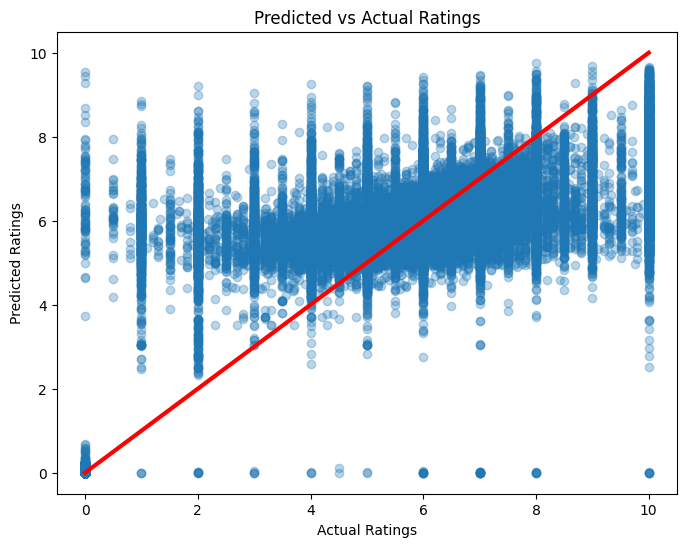

In [287]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.plot([0, 10], [0, 10], 'r', lw=3)  # Perfect prediction line
plt.show()